# **Analysis of oil prices and the financial market** 
by Steve Han & Andrew Daulton
<br>
<br>
This notebook accompanies the "Data Manipulation Methods" and "Analysis & Visualization" sections of the written report created by Steve Han and Andrew Daulton. The following code is intended to show the data manipulation, analysis, and visualizations for the comparison between oil prices and financial prices for each of the eleven business sectors. 
<br>
<br>
Throughout this exploration, 4 Python libraries will be used:
<br>
<br>
[Pandas](https://pandas.pydata.org/): allows for fast and easy data manipulations and analysis
<br>
[Matplotlib](https://matplotlib.org/): allows for easy data visualizations
<br>
[Seaborn](https://seaborn.pydata.org/): allows for more powerful visualizations, built on top of Matplotlib
<br>
[Requests](https://pandas.pydata.org/): allows for HTTP requests to call an API
<br>
<br>
Double check that the libraries are installed with "pip list" or "conda list". If you do not see any of the four libraries, follow the links above to download.

After checking that all of the libraries are installed, we can import into the notebook.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns

We'll first create our function for oil prices. The function will read seven sheets in a .XLS file and return a joined data frame of oil product prices. The .XLS file comes from the U.S. Energy Information Administration (EIA) and can be downloaded [here](https://www.eia.gov/dnav/pet/xls/PET_PRI_SPT_S1_D.xls ).

In [5]:
def oil_prices():
    file = 'PET_PRI_SPT_S1_D.xls' #.XLS file name
    
    # read sheet 'Data 1', skip the first two rows, & drop Brent oil prices
    WTI = pd.read_excel(file, sheet_name='Data 1', skiprows=[0,1]).drop(columns='Europe ' \
        'Brent Spot Price FOB (Dollars per Barrel)') 
    
    WTI = WTI.rename(columns={'Cushing, OK WTI Spot Price FOB (Dollars per Barrel)':'WTI'}) #Pandas .rename() method
    
    WTI['Date'] = pd.to_datetime(WTI['Date']) # convert date column to date time
    
    WTI = WTI.set_index('Date') # set date column as index
    
    conventional_gas = pd.read_excel(file, sheet_name='Data 2', skiprows=[0,1]) # read sheet 'Data 2'

    # calculate average price
    conventional_gas['conventional_gas'] = (conventional_gas.iloc[:,1] + conventional_gas.iloc[:,2])/2 
    
    conventional_gas['Date'] = pd.to_datetime(conventional_gas['Date'])

    conventional_gas = conventional_gas[['Date', 'conventional_gas']].set_index('Date')
    
    regular_gas = pd.read_excel(file, sheet_name='Data 3', skiprows=[0,1]) # read sheet 'Data 3'
    
    regular_gas['Date'] = pd.to_datetime(regular_gas['Date'])
    
    regular_gas = regular_gas.rename(columns={'Los Angeles Reformulated RBOB Regular Gasoline Spot Price '\
        '(Dollars per Gallon)' : 'regular_gas'}).set_index('Date')
    
    heating_oil = pd.read_excel(file, sheet_name='Data 4', skiprows=[0,1]) # read sheet 'Data 4'
    
    heating_oil['Date'] = pd.to_datetime(heating_oil['Date'])
    
    heating_oil = heating_oil.rename(columns={'New York Harbor No. 2 Heating Oil Spot Price FOB (Dollars per Gallon)' \
        : 'heating_oil'}).set_index('Date')
    
    diesel = pd.read_excel(file, sheet_name='Data 5', skiprows=[0,1]) # read sheet 'Data 5'
    
    # filter columns to only return date and diesel prices
    diesel = diesel[['Date', 'Los Angeles, CA Ultra-Low Sulfur CARB Diesel Spot Price (Dollars per Gallon)']]
        
    diesel['Date'] = pd.to_datetime(diesel['Date'])
    
    diesel = diesel.rename(columns={'Los Angeles, CA Ultra-Low Sulfur CARB Diesel Spot Price (Dollars '\
        'per Gallon)':'diesel'}).set_index('Date')
    
    jet_fuel = pd.read_excel(file, sheet_name='Data 6', skiprows=[0,1]) # read sheet 'Data 6'
    
    jet_fuel['Date'] = pd.to_datetime(jet_fuel['Date'])

    jet_fuel = jet_fuel.rename(columns={'U.S. Gulf Coast Kerosene-Type Jet Fuel Spot Price FOB (Dollars per Gallon)': \
        'jet_fuel'}).set_index('Date')
    
    propane = pd.read_excel(file, sheet_name='Data 7', skiprows=[0,1]) # read sheet 'Data 7'
        
    propane['Date'] = pd.to_datetime(propane['Date'])

    propane = propane.rename(columns={'Mont Belvieu, TX Propane Spot Price FOB (Dollars per Gallon)': \
        'propane'}).set_index('Date')
    
    #products = [WTI, conventional_gas, regular_gas, heating_oil, diesel, jet_fuel, propane]
    
    oil_prices = WTI.join([conventional_gas, regular_gas, heating_oil, diesel, jet_fuel, propane], \
                          how='inner')
    
    return oil_prices

In [6]:
oil_df = oil_prices()
oil_df.head()

,WTI,conventional_gas,regular_gas,heating_oil,diesel,jet_fuel,propane
Date,,,,,,,
2003-03-11,36.81,1.0360,1.510,1.166,1.175,1.031,0.654
2003-03-12,37.87,1.0525,1.565,1.155,1.170,1.021,0.645
2003-03-13,36.05,0.9970,1.549,1.068,1.115,0.929,0.625
2003-03-14,35.41,0.9920,1.505,1.023,1.115,0.908,0.601
2003-03-17,34.92,0.9710,1.425,0.957,1.055,0.881,0.616


We'll now need a function that calls the IEX API and returns a data frame of historical prices for a given stock. Documentation of the IEX API can be found [here](https://iexcloud.io/docs/api/) and registration for an API key can be done [here](https://iexcloud.io/cloud-login#/register).

In [8]:
def iex_15year(symbol, sector, key): 
    
    base_url = 'https://cloud.iexapis.com/stable' # create base url to access 
    
    endpoint = '/stock/{}/chart/15y?token={}'.format(symbol, key) # create endpoint of url
    
    url = base_url + endpoint # combine base and endpoint url

    get_url = requests.get(url) # request url 

    convert_json = get_url.json() # convert url output to json 

    df = pd.DataFrame(convert_json) # convert json to pandas data frame 

    df = df[['date', 'close']] # filter data frame to only date and closing price
    
    df.rename(columns={'close':'{}'.format(sector)}, inplace=True) # rename close price column to the business sector

    df['date'] = pd.to_datetime(df['date']) # case date column to datetime
    
    df = df.set_index('date') # set date column as index

    return df

In [9]:
energy_df = iex_15year('XLE', 'energy', 'pk_02b1cd25b1a4443a8019fb5ed1956680')
energy_df.head()

,energy
date,
2007-03-01,56.72
2007-03-02,56.05
2007-03-05,55.40
2007-03-06,56.45
2007-03-07,57.15


With two functions created to access both of the data sets, we'll need a third function to call the IEX API for each business sector + the S&P 500 and join these data frames with the data frame of oil prices from EIA.

In [11]:
def oil_finance_joined(key):
    petroleum = oil_prices() # call function to return joined EIA data
    
    XLE = iex_15year('XLE', 'energy', key) # call IEX for XLE energy sector prices
    XLB = iex_15year('XLB', 'materials', key) # call IEX for XLB materials sector prices
    XLY = iex_15year('XLY', 'consumer_discretionary', key) # call IEX for XLY consumer discretionary sector prices
    XLP = iex_15year('XLP', 'consumer_staples', key) # call IEX for XLP consumer staples sector prices
    XLI = iex_15year('XLI', 'industrial', key) # call IEX for XLI industrial sector prices
    XLU = iex_15year('XLU', 'utilities', key) # call IEX for XLU utilities sector prices
    XLV = iex_15year('XLV', 'health_care', key) # call IEX for XLV health care sector prices
    XLF = iex_15year('XLF', 'financial', key) # call IEX for XLF financial sector prices
    IGM = iex_15year('IGM', 'technology', key) # call IEX for IGM technology sector prices
    IXP = iex_15year('IXP', 'communication', key) # call IEX for IXP communication sector prices
    IYR = iex_15year('IYR', 'real_estate', key) # call IEX for IYR real estate sector prices
    SPY = iex_15year('SPY', 'SP500', key) # call IEX for SP500 financial market prices

    # join IEX data and EIA data
    oil_finance_df = petroleum.join([XLE, XLB, XLY, XLP, XLI, XLU, XLV, XLF, IGM, IXP, \
        IYR, SPY], how='inner')
    
    # reset the index and rename the index column to "Date"
    oil_finance_df = oil_finance_df.reset_index().rename(columns={'index':'Date'})

    return oil_finance_df

In [12]:
oil_finance_df = oil_finance_joined('pk_02b1cd25b1a4443a8019fb5ed1956680')
oil_finance_df.head()

,Date,WTI,conventional_gas,regular_gas,heating_oil,diesel,jet_fuel,propane,energy,materials,consumer_discretionary,consumer_staples,industrial,utilities,health_care,financial,technology,communication,real_estate,SP500
0,2007-03-27,62.98,1.9650,2.553,1.784,2.110,1.918,1.064,60.75,38.07,38.23,26.48,35.89,39.96,33.73,35.80,51.82,65.57,84.99,142.86
1,2007-03-28,64.11,1.9465,2.479,1.814,2.174,1.950,1.086,60.74,37.69,37.80,26.43,35.60,39.88,33.50,35.35,51.32,64.81,84.00,141.82
2,2007-03-29,66.10,2.0265,2.562,1.870,2.222,2.026,1.109,61.12,37.98,37.93,26.58,35.59,40.11,33.66,35.53,51.26,65.80,84.45,141.97
3,2007-03-30,65.94,2.0080,2.538,1.871,2.203,2.017,1.095,60.28,38.05,38.03,26.65,35.55,39.70,33.65,35.63,51.23,65.69,85.24,142.00
4,2007-04-02,66.03,2.0060,2.526,1.859,2.195,2.008,1.083,60.87,38.04,38.16,26.72,35.61,40.65,33.83,35.30,51.38,66.30,86.25,142.16


With all of the data joined into a data frame, the time series analysis can begin. Using Matplotlib, we will create a function that returns a 4 x 3 visualization of line graphs comparing the WTI price to each business sector and the S&P 500.

In [16]:
def prices_time_series(key):
    # create a list of business & S%P 500, to be compared to the WTI price
    sectors = ['energy', 'materials', 'consumer_discretionary', 'consumer_staples', 'industrial', 'utilities', 
                'health_care', 'financial', 'technology', 'communication', 'real_estate', 'SP500']
    
    fig, ax = plt.subplots(4, 3, figsize=(12,12)) # create a 4 x 3 figure that is the size (12,12)
    
    ax = ax.flatten() # flatten array
    
    prices_df = oil_finance_joined(key) # returned join data frame of EIA & IEX data

    # loop through the list of business sectors and create line graphs to compare sectors to the WTI price
    i=0
    for sector in sectors:
        # plot WTI prices
        ax[i].plot(prices_df['Date'], prices_df['WTI'], label = "WTI", color="red")
        # plot sector prices
        ax[i].plot(prices_df['Date'], prices_df['{}'.format(sector)], label = '{}'.format(sector), color='blue')
        ax[i].title.set_text('WTI vs {}'.format(sector)) # set title for axes
        ax[i].set_ylabel('price ($)') # set y axis name
        ax[i].set_xlabel('date') # set x axis name
        ax[i].legend(prop={'size': 7.4}) # include legend for each line visualization
        i+=1

    fig.tight_layout()

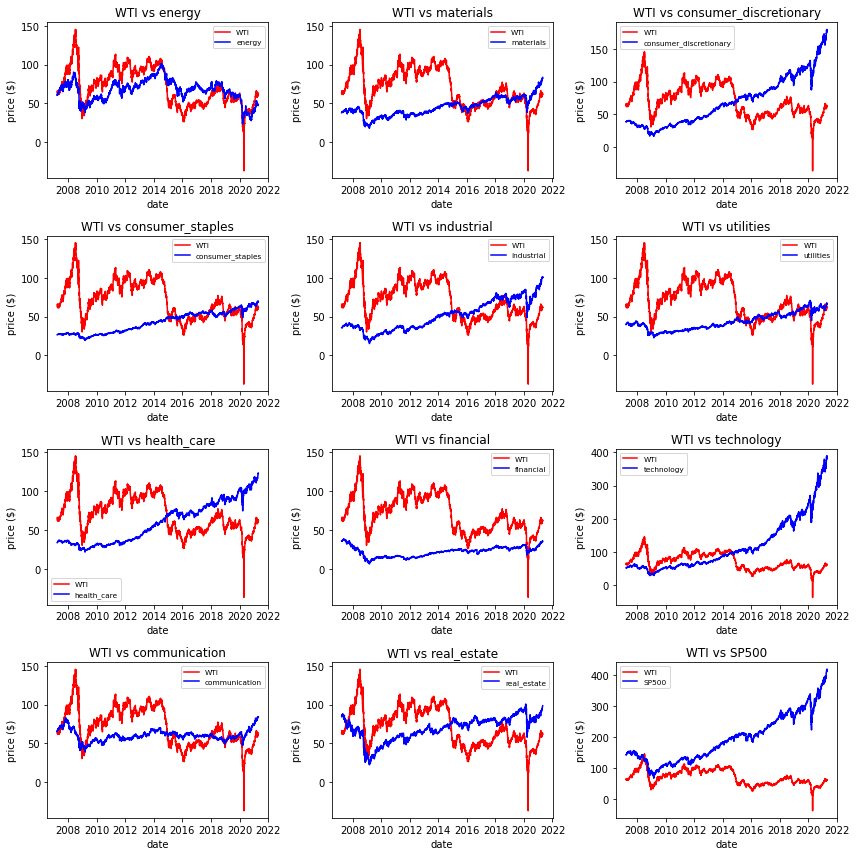

In [18]:
prices_time_series('pk_02b1cd25b1a4443a8019fb5ed1956680')

To quantifty the relationship between between oil and business sector prices, we can create a heatmap showing the correlation coefficient for each of these prices. We will use Seaborn to create a heatmap and use Pandas .corr() method to calculate correlation coefficients for each price.

In [19]:
def correlation_heatmap_wti(key):
    fig, ax = plt.subplots(figsize=(9,9)) # create figure size (9,9)
    
    prices_df = oil_finance_joined(key) # return joined data frame of EIA & IEX data
    
    # filter data frame to return WTI price, eleven business sectors, and the S&P 500
    prices_df = prices_df[['WTI', 'energy', 'materials', 'consumer_discretionary', \
                           'consumer_staples', 'industrial', 'utilities', 'health_care', \
                           'financial', 'technology', 'communication', 'real_estate', \
                           'SP500']]

    heatmap = sns.heatmap(prices_df.corr(), vmin=-1, vmax=1, annot=True) # calculate correlation and plot as heatmap

    # set title of the heat map with font size 12
    heatmap.set_title('WTI Spot Price & Indices Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

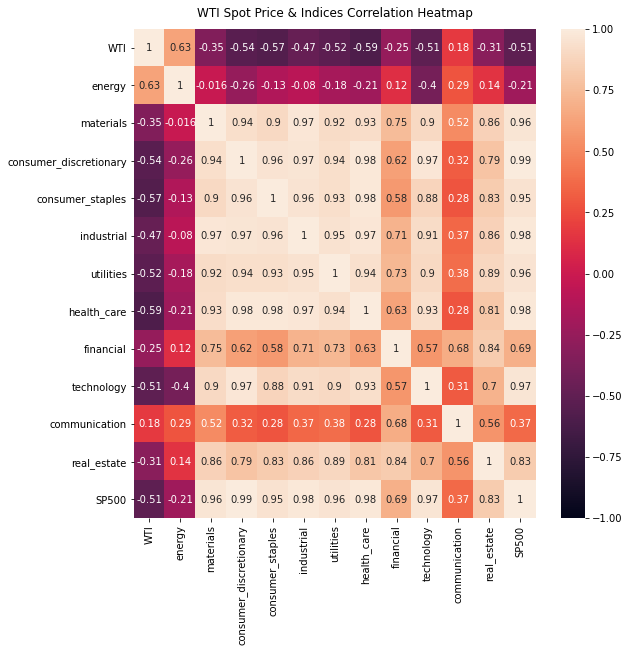

In [20]:
correlation_heatmap_wti('pk_02b1cd25b1a4443a8019fb5ed1956680')

We can also create a similar function to visualize the correlation between all of the oil prices. 

In [21]:
def correlation_heatmap_petroleum():
    fig, ax = plt.subplots(figsize=(9,9)) # create figure size (9,9)
    
    # return only EIA data frame
    petroleum = oil_prices()

    heatmap = sns.heatmap(petroleum.corr(), vmin=-1, vmax=1, annot=True) # calculate correlation and plot as heatmap

    # set title of the heat map with font size 12
    heatmap.set_title('Petroleum Product Prices Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

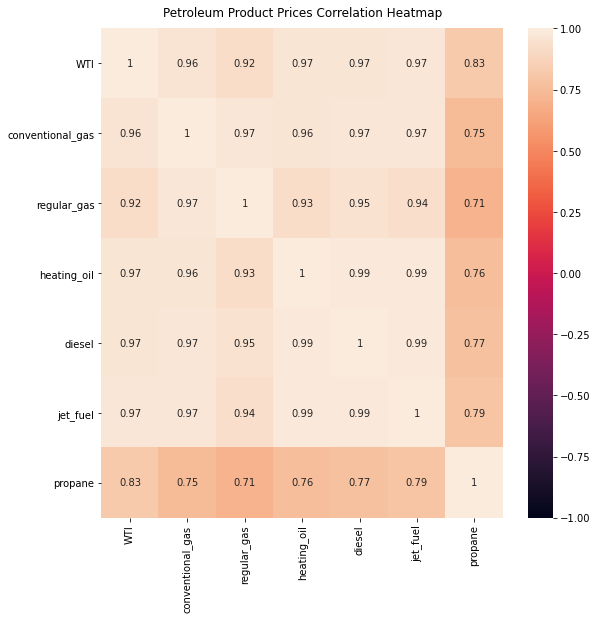

In [23]:
correlation_heatmap_petroleum()